In [22]:
# STEP 1: Import Libraries
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [23]:
# STEP 2: Load Raw Data
print("📥 Loading data...")
df = pd.read_excel("D:/Hackathon Dataset.xlsx", sheet_name="Raw Data")

📥 Loading data...


In [24]:
# STEP 3: Filter for Manufacturing Industry
print("🏭 Filtering for manufacturing records...")
df = df[df['NAICS Desc'].str.contains('Manufacturing', na=False, case=False)]

🏭 Filtering for manufacturing records...


In [25]:
# STEP 4: Filter for Hand-Related Injuries
print("🖐️ Filtering for hand-related injuries...")
keywords = ['hand', 'finger', 'thumb']
df = df[
    df['General Part of Body'].str.contains('|'.join(keywords), na=False, case=False) |
    df['Final Narrative'].str.contains('|'.join(keywords), na=False, case=False)
]

🖐️ Filtering for hand-related injuries...


In [26]:
# STEP 5: Convert EventDate and Extract Month
print("📅 Cleaning date formats...")
df['EventDate'] = pd.to_datetime(df['EventDate'], errors='coerce')
df['Month'] = df['EventDate'].dt.to_period('M')

📅 Cleaning date formats...


In [27]:
# STEP 6: Drop rows with missing Final Narrative
print("🧹 Dropping rows with missing narratives...")
df = df.dropna(subset=['Final Narrative'])


🧹 Dropping rows with missing narratives...


In [28]:
# STEP 7: Clean Narrative Text for NLP
print("🧼 Cleaning text for NLP...")
df['Cleaned Narrative'] = df['Final Narrative'].str.lower().apply(
    lambda x: re.sub(r'[^a-z\s]', '', x)
)


🧼 Cleaning text for NLP...


In [29]:
# STEP 8: Tag Likely Cause (Expanded Rule-Based)
print("🧠 Tagging likely cause of injury...")
def tag_cause(text):
    if pd.isnull(text): return 'Unknown'
    text = text.lower()

    # Safety & Behavior Triggers
    if 'slip' in text or 'fall' in text:
        return 'Slipping/Tripping'
    if 'unguarded' in text or 'guard' in text:
        return 'Unguarded Equipment'
    if 'pinch' in text or 'crush' in text or 'jammed' in text:
        return 'Pinch/Crush Injury'
    if 'caught' in text:
        return 'Caught-In Machinery'

    # Machine/Tool Involvement
    if 'saw' in text:
        return 'Machine Saw'
    if 'press' in text or 'die' in text:
        return 'Hydraulic/Trim Press'
    if 'lathe' in text:
        return 'Lathe Machine'
    if 'knife' in text or 'blade' in text or 'cutter' in text:
        return 'Knife/Blade'
    if 'conveyor' in text:
        return 'Conveyor'
    if 'drill' in text:
        return 'Drill'
    if 'grinder' in text:
        return 'Grinder'
    if 'shear' in text:
        return 'Shearing Machine'
    if 'bender' in text:
        return 'Bender Machine'
    if 'roll former' in text:
        return 'Roll Forming Machine'
    if 'bagging' in text or 'packaging' in text:
        return 'Packaging Machine'
    if 'sandblast' in text:
        return 'Sandblasting Equipment'
    if 'crane' in text or 'hoist' in text:
        return 'Crane/Lift'
    if 'switch' in text or 'panel' in text or 'control' in text:
        return 'Electrical Controls'

    return 'Other'

df['Likely Cause'] = df['Cleaned Narrative'].apply(tag_cause)


🧠 Tagging likely cause of injury...


In [30]:
# STEP 9: Tag Cleaned Source (Expanded Machinery Detection)
print("🔧 Extracting machine/object type from narrative...")
def clean_source_from_narrative(text):
    if pd.isnull(text): return "Unknown"
    text = text.lower()

    if 'saw' in text:
        return 'Machine Saw'
    if 'knife' in text or 'blade' in text or 'cutter' in text:
        return 'Knife/Blade'
    if 'press' in text or 'die' in text or 'trim die' in text:
        return 'Hydraulic/Trim Press'
    if 'roll former' in text:
        return 'Roll Forming Machine'
    if 'punch' in text:
        return 'Punch Press'
    if 'mold' in text:
        return 'Molding Machine'
    if 'lathe' in text:
        return 'Lathe Machine'
    if 'drill' in text:
        return 'Drill'
    if 'grinder' in text:
        return 'Grinder'
    if 'shear' in text:
        return 'Shearing Machine'
    if 'mill' in text or 'milling' in text:
        return 'Milling Machine'
    if 'conveyor' in text:
        return 'Conveyor'
    if 'bagging' in text:
        return 'Packaging Machine'
    if 'canning line' in text:
        return 'Canning Line'
    if 'bender' in text:
        return 'Bender Machine'
    if 'winder' in text:
        return 'Winder/Rewinder'
    if 'marking' in text or 'labeler' in text:
        return 'Marking/Labeling Machine'
    if 'sandblast' in text:
        return 'Sandblasting Equipment'
    if 'cleaning' in text:
        return 'Cleaning Equipment'
    if 'switch' in text or 'panel' in text or 'control' in text:
        return 'Electrical Controls'
    if 'crane' in text or 'hoist' in text or 'lift' in text:
        return 'Crane/Lift'
    if 'pinch' in text:
        return 'Pinch Point'

    return 'Other'

df['Cleaned Source'] = df['Cleaned Narrative'].apply(clean_source_from_narrative)


🔧 Extracting machine/object type from narrative...


🧾 Extracting top keywords...


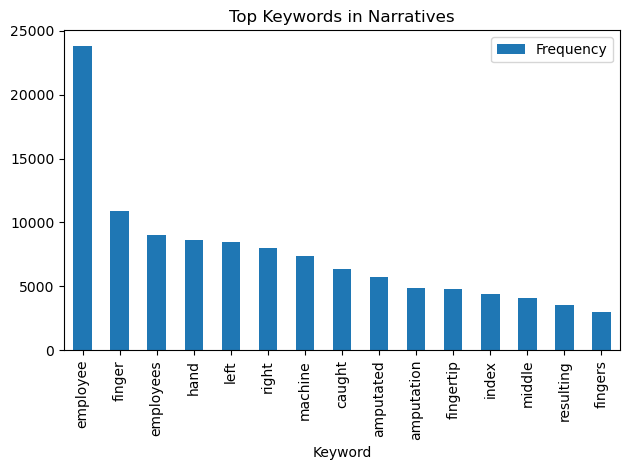

In [31]:
# STEP 10: Keyword Extraction using CountVectorizer
print("🧾 Extracting top keywords...")
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df['Cleaned Narrative'])
keywords = vectorizer.get_feature_names_out()
keyword_freq = X.toarray().sum(axis=0)
keyword_df = pd.DataFrame({'Keyword': keywords, 'Frequency': keyword_freq})
keyword_df = keyword_df.sort_values(by='Frequency', ascending=False)

# Optional: Show top keywords chart
keyword_df.head(15).plot(x='Keyword', y='Frequency', kind='bar', title="Top Keywords in Narratives")
plt.tight_layout()
plt.show()


In [32]:
# STEP 11: Entity Extraction using spaCy (BONUS)
print("📦 Extracting entities using spaCy...")
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return ', '.join(entities) if entities else "None"

df['Narrative Entities'] = df['Cleaned Narrative'].apply(extract_entities)

📦 Extracting entities using spaCy...


In [35]:
# STEP 12: Final Export for Power BI
print("💾 Exporting final file for Power BI...")
df.to_csv("hand_injuries_with_machines.csv", index=False)
print("✅ Done! File saved as: hand_injuries_with_machines.csv")


💾 Exporting final file for Power BI...
✅ Done! File saved as: hand_injuries_with_machines.csv
